In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
from paths import *
from SM_tools import *
from re import search
from os import listdir
from os.path import isfile, join
from numpy import genfromtxt
from scipy.stats import rankdata
import rasterio as rio
import earthpy.spatial as es
import cartopy.crs as ccrs
from scipy import stats
from numpy import genfromtxt
from numpy import trapz

In [2]:
#select the water year of interest 
water_year = 2019

#start date
st = str(water_year -1) +'-09-01'
#end date
ed = str(water_year)+'-09-30'

# snotel swe timeseries 
snotel_swe_all = pd.read_csv(dataPath + 'SNOTEL_data_SWEDmeters'+ str(water_year -1) +'-09-01_'+str(water_year)+'-09-30.csv', index_col=0, parse_dates=True)


In [8]:
#for testing 
ss = xr.open_dataset(assim_file_path +'skill_scores_'+str(water_year)+'.nc')
ss

<xarray.Dataset>
Dimensions:    (assim_run: 86, metrics: 5, station: 10)
Coordinates:
  * assim_run  (assim_run) object 'baseline' 'both_M_1' ... 'snotel_tc_1'
  * station    (station) object '577_WY_SNTL' '585_WY_SNTL' ... '831_WY_SNTL'
  * metrics    (metrics) object 'R2' 'MBE' 'RMSE' 'NSE' 'KGE'
Data variables:
    score      (assim_run, station, metrics) float64 ...
Attributes:
    description:   Performance metrics at stations
    model_output:  R^2 MBE RMSE NSE KGE

# skillscore heatmaps

In [9]:
#heatmap
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (N, M).
    row_labels
        A list or array of length N with the labels for the rows.
    col_labels
        A list or array of length M with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, vmin=-1, vmax=1, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    for edge, spine in ax.spines.items():
        spine.set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar

# textcolors=["black", "white"],
def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=["black","black"],
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A list or array of two color specifications.  The first is used for
        values below a threshold, the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

In [10]:
ss.assim_run.values

array(['baseline', 'both_M_1', 'both_M_11', 'both_M_12', 'both_M_2',
       'both_all', 'both_aspect_0.0', 'both_aspect_2.0',
       'both_aspect_4.0', 'both_aspect_6.0', 'both_day_delta10',
       'both_day_delta3', 'both_day_delta5', 'both_day_delta7',
       'both_elev_1', 'both_elev_2', 'both_elev_3', 'both_elev_4',
       'both_lc_1.0', 'both_lc_12.0', 'both_lc_6.0', 'both_slope_0',
       'both_slope_1', 'both_tc_0', 'both_tc_1', 'both_tc_2', 'both_tc_3',
       'both_tc_4', 'cso_M_1', 'cso_M_11', 'cso_M_12', 'cso_M_2',
       'cso_M_3', 'cso_M_4', 'cso_all', 'cso_aspect_0.0',
       'cso_aspect_2.0', 'cso_aspect_4.0', 'cso_aspect_6.0',
       'cso_aspect_8.0', 'cso_day_delta10', 'cso_day_delta3',
       'cso_day_delta5', 'cso_day_delta7', 'cso_elev_0', 'cso_elev_1',
       'cso_elev_2', 'cso_elev_3', 'cso_elev_4', 'cso_lc_1.0',
       'cso_lc_12.0', 'cso_lc_2.0', 'cso_lc_21.0', 'cso_lc_24.0',
       'cso_lc_6.0', 'cso_lc_9.0', 'cso_slope_0', 'cso_slope_1',
       'cso_slope_2', 

In [11]:
mean_stats = ss.score.mean(axis = 1)
mean_stats

<xarray.DataArray 'score' (assim_run: 86, metrics: 5)>
array([[ 0.62197575, -0.13464754,  0.19042774,  0.14589076,  0.46841266],
       [ 0.62710888, -0.13618416,  0.19045303,  0.15263544,  0.46958343],
       [ 0.6032174 , -0.10245649,  0.17145263,  0.30668748,  0.55611475],
       [ 0.61259905, -0.0985258 ,  0.16935015,  0.32139459,  0.56818163],
       [ 0.62796402, -0.09801589,  0.16587774,  0.33414274,  0.58856078],
       [ 0.74346323, -0.12036988,  0.16345947,  0.3581953 ,  0.6094966 ],
       [ 0.55829772, -0.15320233,  0.2112858 , -0.03557533,  0.32843878],
       [ 0.6847096 , -0.12146413,  0.17156017,  0.29860027,  0.57370622],
       [ 0.62889961, -0.12151445,  0.1767195 ,  0.22877706,  0.5293448 ],
       [ 0.68792533, -0.11304005,  0.16716119,  0.338917  ,  0.57243488],
       [ 0.69858433, -0.07835273,  0.1410642 ,  0.49249632,  0.7008215 ],
       [ 0.72208888, -0.07577983,  0.13505177,  0.52023734,  0.71723751],
       [ 0.70216416, -0.08109965,  0.14036465,  0.48324028,  0.69492314],
       [ 0.72677387, -0.07445986,  0.13549348,  0.53298312,  0.72706067],
       [ 0.73874412, -0.11455045,  0.16407916,  0.37639246,  0.64166789],
       [ 0.72435949, -0.12497262,  0.17028455,  0.31810813,  0.59396105],
       [ 0.60184992, -0.13710802,  0.1934527 ,  0.11550711,  0.41867834],
       [ 0.6146648 , -0.13496064,  0.19164274,  0.14044882,  0.44824593],
       [ 0.74122941, -0.1202877 ,  0.16329026,  0.36200988,  0.61806313],
       [ 0.54252303, -0.11955408,  0.19173048,  0.11168526,  0.39296931],
       [ 0.66972132, -0.12338084,  0.17705082,  0.26881569,  0.53156965],
       [ 0.72306446, -0.12868894,  0.1724175 ,  0.29231485,  0.56602512],
       [ 0.68669771, -0.11269634,  0.16922077,  0.3356262 ,  0.58243545],
       [ 0.66970511, -0.13624643,  0.18337436,  0.18904986,  0.48814626],
       [ 0.67753251, -0.11234335,  0.1692065 ,  0.33090919,  0.57322217],
       [ 0.72427173,  0.11792252,  0.25396942, -1.31027706, -0.4593075 ],
       [ 0.61360673, -0.02331757,  0.1644849 ,  0.28222027,  0.61405453],
       [ 0.64952493, -0.06397711,  0.1551504 ,  0.40966172,  0.67198918],
       [ 0.61323715, -0.12003782,  0.18406554,  0.19996298,  0.50186179],
       [ 0.62604257, -0.12218973,  0.18198772,  0.22188619,  0.52136955],
       [ 0.66363475, -0.06015411,  0.15320145,  0.41927704,  0.68189115],
       [ 0.65439615, -0.1055879 ,  0.16947463,  0.32270259,  0.59575498],
       [ 0.62402494, -0.17474404,  0.22161559, -0.15332802,  0.26237919],
       [ 0.56595422, -0.16540518,  0.21760843, -0.1306448 ,  0.26915298],
       [ 0.73421216, -0.02740666,  0.14590066,  0.41126879,  0.67436725],
       [ 0.6707883 , -0.04067056,  0.14843826,  0.43222955,  0.68942222],
       [ 0.68191767, -0.01565167,  0.15175838,  0.37190276,  0.6574786 ],
       [ 0.76531352,  0.00315918,  0.16069048,  0.21208928,  0.51538887],
       [ 0.69184243, -0.05740218,  0.15405426,  0.40286871,  0.67752917],
       [ 0.62866512,  0.00832326,  0.18088702,  0.0430135 ,  0.48291144],
       [ 0.51782684, -0.0376032 ,  0.18206144,  0.14265633,  0.55780033],
       [ 0.52319833, -0.07354389,  0.18177195,  0.18705999,  0.53663367],
       [ 0.54083161, -0.04345446,  0.18540617,  0.09582428,  0.52879159],
       [ 0.75172584, -0.01568036,  0.14739363,  0.35940026,  0.6367044 ],
       [ 0.73286524, -0.09489886,  0.15967402,  0.37870201,  0.66228153],
       [ 0.605124  , -0.11115778,  0.18500422,  0.16127892,  0.56306324],
       [ 0.51769308, -0.03663831,  0.1894593 ,  0.04895763,  0.51525971],
       [ 0.45167645, -0.1130975 ,  0.19847823,  0.05222843,  0.43712053],
       [ 0.75600199, -0.03747041,  0.141218  ,  0.47013421,  0.69797117],
       [ 0.80764891,  0.01600696,  0.15324505,  0.18666266,  0.49297377],
       [ 0.48822912, -0.07418552,  0.1940687 ,  0.03104527,  0.50583261],
       [ 0.5577297 , -0.06933782,  0.17394932,  0.2513364 ,  0.58667561],
       [ 0.62697352, -0.03602053,  0.15514702,  0.40782674,  0.65166325],
       [ 0.77170376,  0

Text(0, 0.5, 'statistic')

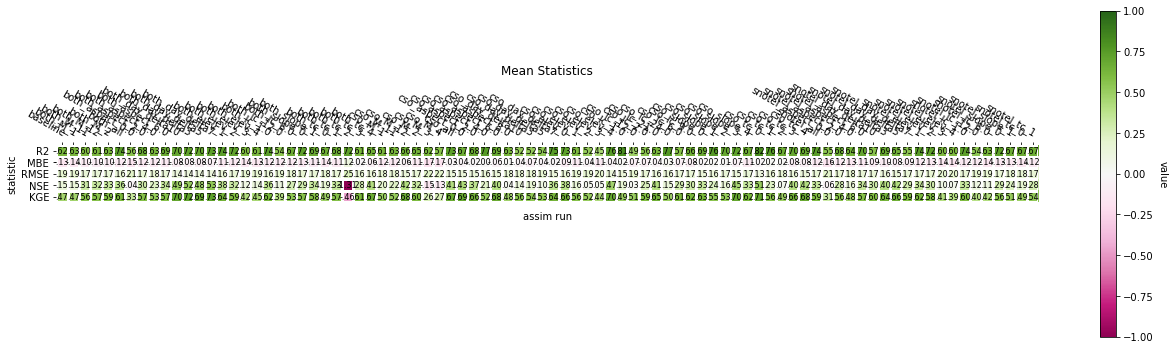

In [12]:
def func(x, pos):
    return "{:.2f}".format(x).replace("0.", ".").replace("1.00", "")
#WA figsize=(8,16)
fig, ax = plt.subplots(1, figsize=(22,6))

im, _ = heatmap(np.transpose(mean_stats.values), ss.metrics.values, ss.assim_run.values, ax=ax,
                   cmap="PiYG", cbarlabel="value")
annotate_heatmap(im, valfmt=matplotlib.ticker.FuncFormatter(func), size=8)
ax.set_title('Mean Statistics')
ax.set_xlabel('assim run')
ax.set_ylabel('statistic')

In [13]:
path = fig_path + 'heatmap'+str(water_year)+'.png'
fig.savefig(path, dpi=300)

In [14]:
#rank the assim runs based on KGE value
rank = len(mean_stats.loc[:,'KGE'].values) - rankdata(mean_stats.loc[:,'KGE'].values).astype(int)
rank

array([72, 71, 49, 43, 35, 28, 81, 39, 56, 42,  3,  1,  6,  0, 18, 32, 76,
       73, 25, 80, 54, 44, 37, 67, 41, 85, 26, 12, 63, 58,  9, 31, 84, 83,
       11,  7, 15, 59, 10, 69, 47, 53, 57, 20, 14, 45, 60, 74,  5, 65, 62,
       36, 17, 64, 27, 22, 21, 51, 55,  4, 23,  2, 50, 68, 13,  8, 33, 82,
       48, 70, 40, 29, 19, 16, 34, 24, 38, 77, 79, 30, 78, 75, 46, 61, 66,
       52])

In [15]:
#print ranked list of assim runs
ranked_runs = []
for i in range(len(rank)):
    print(mean_stats.assim_run[rank==i].values[0],mean_stats.loc[:,'KGE'].values[rank == i])
    ranked_runs.append(mean_stats.assim_run[rank==i].values[0])

both_day_delta7 [0.72706067]
both_day_delta3 [0.71723751]
cso_tc_0 [0.70807452]
both_day_delta10 [0.7008215]
cso_slope_3 [0.70055637]
cso_elev_4 [0.69797117]
both_day_delta5 [0.69492314]
cso_aspect_0.0 [0.68942222]
cso_tc_4 [0.68225269]
cso_M_12 [0.68189115]
cso_aspect_6.0 [0.67752917]
cso_all [0.67436725]
both_tc_4 [0.67198918]
cso_tc_3 [0.66400206]
cso_elev_0 [0.66228153]
cso_aspect_2.0 [0.6574786]
snotel_day_delta5 [0.65592089]
cso_lc_21.0 [0.65166325]
both_elev_1 [0.64166789]
snotel_day_delta3 [0.63783036]
cso_day_delta7 [0.6367044]
cso_slope_0 [0.62990603]
cso_lc_9.0 [0.62278625]
cso_slope_4 [0.62116612]
snotel_elev_1 [0.61827777]
both_lc_1.0 [0.61806313]
both_tc_3 [0.61405453]
cso_lc_6.0 [0.61124645]
both_all [0.6094966]
snotel_day_delta10 [0.59962761]
snotel_lc_1.0 [0.59784781]
cso_M_2 [0.59575498]
both_elev_2 [0.59396105]
snotel_all [0.58913304]
snotel_day_delta7 [0.58872462]
both_M_2 [0.58856078]
cso_lc_2.0 [0.58667561]
both_slope_1 [0.58243545]
snotel_elev_2 [0.58103717]
both

In [16]:
#  find number of assimilation runs that performed better than the baseline run 
#index of snotel assimilation runs
snotel = [i for i, x in enumerate(mean_stats.assim_run.values) if search('snotel', x)]
#index of cso assimilation runs
cso = [i for i, x in enumerate(mean_stats.assim_run.values) if search('cso', x)]
#index of base SM runs
base = [i for i, x in enumerate(mean_stats.assim_run.values) if search('bas', x)]
#index of combination cso & snotel SM runs
both = [i for i, x in enumerate(mean_stats.assim_run.values) if search('both', x)]



In [17]:
#percent of snotel assim runs that performed better than baseline
print('percent of snotel assim runs that performed better than baseline =', len(rank[snotel][rank[snotel] < rank[base]])/len(rank[snotel]))

#percent of cso assim runs that performed better than baseline
print('percent of cso assim runs that performed better than baseline =', len(rank[cso][rank[cso] < rank[base]])/len(rank[cso]))

#percent of combined assim runs that performed better than baseline
print('percent of combined assim runs that performed better than baseline =', len(rank[both][rank[both] < rank[base]])/len(rank[both]))

percent of snotel assim runs that performed better than baseline = 0.75
percent of cso assim runs that performed better than baseline = 0.9210526315789473
percent of combined assim runs that performed better than baseline = 0.8148148148148148


In [18]:
snotel_stats = mean_stats[snotel,:]
snotel_rank = len(snotel_stats.loc[:,'KGE'].values) - rankdata(snotel_stats.loc[:,'KGE'].values).astype(int)
for i in range(len(snotel_rank)):
    print(snotel_stats.assim_run[snotel_rank==i].values[0])

snotel_day_delta5
snotel_day_delta3
snotel_elev_1
snotel_day_delta10
snotel_lc_1.0
snotel_all
snotel_day_delta7
snotel_elev_2
snotel_aspect_6.0
snotel_slope_0
snotel_aspect_2.0
snotel_tc_1
snotel_slope_1
snotel_tc_0
snotel_aspect_4.0
snotel_lc_6.0
snotel_elev_3
snotel_lc_12.0
snotel_elev_4
snotel_aspect_0.0


In [19]:
cso_stats = mean_stats[cso,:]
cso_rank = len(cso_stats.loc[:,'KGE'].values) - rankdata(cso_stats.loc[:,'KGE'].values).astype(int)
for i in range(len(cso_rank)):
    print(cso_stats.assim_run[cso_rank==i].values[0],cso_stats.loc[cso_rank==i,'KGE'].values)

cso_tc_0 [0.70807452]
cso_slope_3 [0.70055637]
cso_elev_4 [0.69797117]
cso_aspect_0.0 [0.68942222]
cso_tc_4 [0.68225269]
cso_M_12 [0.68189115]
cso_aspect_6.0 [0.67752917]
cso_all [0.67436725]
cso_tc_3 [0.66400206]
cso_elev_0 [0.66228153]
cso_aspect_2.0 [0.6574786]
cso_lc_21.0 [0.65166325]
cso_day_delta7 [0.6367044]
cso_slope_0 [0.62990603]
cso_lc_9.0 [0.62278625]
cso_slope_4 [0.62116612]
cso_lc_6.0 [0.61124645]
cso_M_2 [0.59575498]
cso_lc_2.0 [0.58667561]
cso_elev_1 [0.56306324]
cso_day_delta10 [0.55780033]
cso_tc_1 [0.55507996]
cso_slope_1 [0.55014667]
cso_day_delta3 [0.53663367]
cso_slope_2 [0.53066679]
cso_day_delta5 [0.52879159]
cso_M_11 [0.52136955]
cso_aspect_4.0 [0.51538887]
cso_elev_2 [0.51525971]
cso_lc_12.0 [0.50583261]
cso_M_1 [0.50186179]
cso_lc_24.0 [0.4978726]
cso_lc_1.0 [0.49297377]
cso_tc_2 [0.48666688]
cso_aspect_8.0 [0.48291144]
cso_elev_3 [0.43712053]
cso_M_4 [0.26915298]
cso_M_3 [0.26237919]


In [20]:
both_stats = mean_stats[both,:]
both_rank = len(both_stats.loc[:,'KGE'].values) - rankdata(both_stats.loc[:,'KGE'].values).astype(int)
for i in range(len(both_rank)):
    print(both_stats.assim_run[both_rank==i].values[0])

both_day_delta7
both_day_delta3
both_day_delta10
both_day_delta5
both_tc_4
both_elev_1
both_lc_1.0
both_tc_3
both_all
both_elev_2
both_M_2
both_slope_1
both_aspect_2.0
both_tc_1
both_aspect_6.0
both_M_12
both_slope_0
both_M_11
both_lc_6.0
both_aspect_4.0
both_tc_0
both_M_1
both_elev_4
both_elev_3
both_lc_12.0
both_aspect_0.0
both_tc_2


In [16]:
# NSE = data.cal_metrics.loc[:,"NSE",:]
# nse_top = np.amax(data.cal_metrics.loc[:,"NSE",:],axis = 0)
# KGE = data.cal_metrics.loc[:,"KGE",:]
# kge_top = np.amax(data.cal_metrics.loc[:,"KGE",:],axis = 0)
# RMSE = data.cal_metrics.loc[:,"RMSE",:]
# rmse_top = np.amin(data.cal_metrics.loc[:,"RMSE",:],axis = 0)
# R_2 = data.cal_metrics.loc[:,"R2",:]
# r2_top = np.amax(data.cal_metrics.loc[:,"R2",:],axis = 0)
# MBE = data.cal_metrics.loc[:,"MBE",:]
# mbe_top = np.amin(data.cal_metrics.loc[:,"MBE",:],axis = 0)

# monthly skill scores

In [21]:
assim_file_path
#for testing 
ssm = xr.open_dataset(assim_file_path +'monthly_skill_scores_'+str(water_year)+'.nc')
ssm

<xarray.Dataset>
Dimensions:    (assim_run: 65, metrics: 5, month: 12, station: 10)
Coordinates:
  * assim_run  (assim_run) object 'baseline' 'both_all' ... 'snotel_tc_1'
  * station    (station) object '577_WY_SNTL' '585_WY_SNTL' ... '831_WY_SNTL'
  * metrics    (metrics) object 'R2' 'MBE' 'RMSE' 'NSE' 'KGE'
  * month      (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    score      (assim_run, station, month, metrics) float64 ...
Attributes:
    description:   Performance metrics at stations
    model_output:  R^2 MBE RMSE NSE KGE

In [22]:
#create array of monthly mean performance metrics 
monthly_mean_stats = np.empty((len(ssm.month),len(ssm.assim_run),len(ssm.metrics)))
for i in range(len(ssm.month)):
    monthly_mean_stats[i,:,:] = ssm.score[:,:,i,:].mean(axis = 1).values

/nfs/attic/dfh/miniconda/envs/snowmodelcal/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [23]:
for i in range(len(ssm.month)):
    print ('month = ', i)
    mo_stats = ssm.score[:,:,i,:].mean(axis = 1)
    rank = len(mo_stats.loc[:,'KGE'].values) - rankdata(mo_stats.loc[:,'KGE'].values).astype(int)
    print('min KGE =', str(min(mo_stats.loc[:,'KGE'].values)),'max KGE =', str(max(mo_stats.loc[:,'KGE'].values)))
    for j in range(len(rank)):
        print(mo_stats.assim_run.values[rank==j])

month =  0
min KGE = -25.890281540939704 max KGE = -0.9928701053740678
['snotel_day_delta3']
['snotel_day_delta7']
['cso_elev_4']
['cso_elev_0']
[]
[]
[]
[]
['cso_all' 'cso_aspect_0.0' 'cso_day_delta10' 'cso_day_delta3'
 'cso_day_delta5' 'cso_day_delta7' 'cso_elev_3' 'cso_lc_1.0' 'cso_slope_0']
[]
[]
[]
[]
[]
['both_elev_2' 'snotel_elev_2']
['cso_lc_9.0']
['cso_elev_1']
['baseline']
[]
['both_lc_1.0' 'snotel_lc_1.0']
[]
['both_all' 'snotel_all']
[]
['both_slope_0' 'snotel_slope_0']
['snotel_lc_12.0']
[]
['cso_aspect_4.0' 'cso_lc_12.0' 'cso_slope_3']
[]
[]
['both_tc_0' 'snotel_tc_0']
[]
['both_aspect_2.0' 'snotel_aspect_2.0']
[]
['both_slope_1' 'snotel_slope_1']
[]
['both_tc_1' 'snotel_tc_1']
[]
['both_lc_6.0' 'snotel_lc_6.0']
[]
['both_elev_1' 'snotel_elev_1']
['snotel_day_delta10']
[]
['both_aspect_0.0' 'snotel_aspect_0.0']
['snotel_aspect_6.0']
['snotel_day_delta5']
['snotel_M_1']
[]
['cso_aspect_6.0' 'cso_slope_1']
['snotel_elev_3']
['snotel_elev_4']
[]
['both_aspect_4.0' 'snotel_as

In [21]:
i=5
monthly_mean_stats[i,:,4]

array([-0.42985667, -2.21461855, -1.06384718,  0.49327083, -1.61210904,
       -1.28038281, -1.83425716,  0.37766582,  0.53128485,  0.47218017,
        0.53147963,  0.50507746,  0.41773969,  0.14337524,  0.36292523,
        0.62367839,  0.66414035,  0.57959172,  0.62442146,  0.33588701,
        0.63402641,  0.65967353,  0.56117565,  0.62934759,  0.61643742])

In [ ]:
def func(x, pos):
    return "{:.2f}".format(x).replace("0.", ".").replace("1.00", "")
#WA figsize=(8,16)
fig, ax = plt.subplots(1, figsize=(22,6))

im, _ = heatmap(np.transpose(mean_stats.values), ss.metrics.values, ss.assim_run.values, ax=ax,
                   cmap="PiYG", cbarlabel="value")
annotate_heatmap(im, valfmt=matplotlib.ticker.FuncFormatter(func), size=8)
ax.set_title('Mean Statistics')
ax.set_xlabel('assim run')
ax.set_ylabel('statistic')

In [ ]:
Metrics = ['R2','MBE','RMSE','NSE','KGE']
Stations = gdf['code'].values

def func(x, pos):
    return "{:.2f}".format(x).replace("0.", ".").replace("1.00", "")
#WA figsize=(8,16)
fig, ((ax), (ax1), (ax2), (ax3),(ax4),(ax5)) = plt.subplots(6, 1, figsize=(12,16))

im, _ = heatmap(np.transpose(mean_stats.values), ss.metrics.values, ss.assim_run.values, ax=ax,
                   cmap="PiYG", cbarlabel="value")
annotate_heatmap(im, valfmt=matplotlib.ticker.FuncFormatter(func), size=8)


im, cbar = heatmap(data.cal_metrics[top_params[0],:,:], Metrics, Stations, ax=ax,
                   cmap="PiYG", cbarlabel="value")
annotate_heatmap(im, valfmt=matplotlib.ticker.FuncFormatter(func), size=8)
ax.set_title('Top run with metric ='+Metrics[0])

im, _ = heatmap(data.cal_metrics[top_params[1],:,:], Metrics, Stations, ax=ax1,
                   cmap="PiYG", cbarlabel="value")
annotate_heatmap(im, valfmt=matplotlib.ticker.FuncFormatter(func), size=8)
ax1.set_title('Top run with metric ='+Metrics[1])

im, _ = heatmap(data.cal_metrics[top_params[2],:,:], Metrics, Stations, ax=ax2,
                   cmap="PiYG", cbarlabel="value")
annotate_heatmap(im, valfmt=matplotlib.ticker.FuncFormatter(func), size=8)
ax2.set_title('Top run with metric ='+Metrics[2])

im, _ = heatmap(data.cal_metrics[top_params[3],:,:], Metrics, Stations, ax=ax3,
                   cmap="PiYG", cbarlabel="value")
annotate_heatmap(im, valfmt=matplotlib.ticker.FuncFormatter(func), size=8)
ax3.set_title('Top run with metric ='+Metrics[3])

im, _ = heatmap(data.cal_metrics[top_params[4],:,:], Metrics, Stations, ax=ax4,
                   cmap="PiYG", cbarlabel="value")
annotate_heatmap(im, valfmt=matplotlib.ticker.FuncFormatter(func), size=8)
ax4.set_title('Top run with metric ='+Metrics[4])


plt.tight_layout()
plt.show()

In [7]:
mean_stats = moslice.score.mean(axis = 1)
mean_stats

AttributeError: 'DataArray' object has no attribute 'score'

In [ ]:
monthly_mean_stats = np.empty()
mean_stats = ss.score.mean(axis = 1)

## seasonal skill scores

In [21]:
#for testing 
sss = xr.open_dataset(assim_file_path +'seasonal_skill_scores_'+str(water_year)+'.nc')
sss

<xarray.Dataset>
Dimensions:    (assim_run: 86, metrics: 5, season: 2, station: 10)
Coordinates:
  * assim_run  (assim_run) object 'baseline' 'both_M_1' ... 'snotel_tc_1'
  * station    (station) object '577_WY_SNTL' '585_WY_SNTL' ... '831_WY_SNTL'
  * metrics    (metrics) object 'R2' 'MBE' 'RMSE' 'NSE' 'KGE'
  * season     (season) object 'acumulation' 'ablation'
Data variables:
    score      (assim_run, station, season, metrics) float64 ...
Attributes:
    description:   Performance metrics at stations
    model_output:  R^2 MBE RMSE NSE KGE

In [22]:
#create array of monthly mean performance metrics 
seasonal_mean_stats = np.empty((len(sss.season),len(sss.assim_run),len(sss.metrics)))
for i in range(len(sss.season)):
    seasonal_mean_stats[i,:,:] = sss.score[:,:,i,:].mean(axis = 1).values

In [23]:
for i in range(len(sss.season)):
    print ('season = ', i)
    s_stats = sss.score[:,:,i,:].mean(axis = 1)
    rank = len(s_stats.loc[:,'KGE'].values) - rankdata(s_stats.loc[:,'KGE'].values).astype(int)
    print('min KGE =', str(min(s_stats.loc[:,'KGE'].values)),'max KGE =', str(max(s_stats.loc[:,'KGE'].values)))
    for j in range(len(rank)):
        print(s_stats.assim_run.values[rank==j],s_stats.loc[rank==j,'KGE'].values)

season =  0
min KGE = -1.550620928076699 max KGE = 0.9209914326129349
['both_day_delta7'] [0.92099143]
['both_day_delta10'] [0.91630201]
['both_day_delta3'] [0.91528036]
['both_day_delta5'] [0.91471645]
['snotel_day_delta7'] [0.91151616]
['snotel_day_delta10'] [0.90222989]
['snotel_day_delta5'] [0.89949643]
['snotel_day_delta3'] [0.88360719]
['both_M_2'] [0.87849792]
['both_M_11'] [0.87038693]
['both_M_12'] [0.86994226]
['cso_M_2'] [0.86785645]
['both_aspect_4.0'] [0.86005133]
['both_tc_4'] [0.85975557]
['cso_M_12'] [0.84864463]
['cso_slope_3'] [0.84627847]
['both_tc_1'] [0.84569658]
['both_slope_1'] [0.84494194]
['cso_tc_4'] [0.84234014]
['cso_tc_3'] [0.84158938]
['both_aspect_2.0'] [0.83923387]
['cso_slope_4'] [0.83922341]
['cso_lc_6.0'] [0.83625526]
['both_elev_1'] [0.83625133]
['cso_M_11'] [0.83322653]
['cso_lc_2.0'] [0.82927126]
['both_lc_1.0'] [0.82825365]
['both_aspect_6.0'] [0.82556434]
['snotel_aspect_2.0'] [0.82427677]
['both_all'] [0.82311874]
['both_lc_6.0'] [0.82285318]
['

# swe timeseries

In [24]:
assim = xr.open_dataset(assim_file_path +'assim_swe_'+str(water_year)+'.nc')
## add index to gdf 
insites = point_index_from_grid(snotel_eval_sites,dem_path)

In [38]:
np.std(inswe[cso,:],axis =0)/np.mean(inswe[cso,:],axis =0)

/nfs/attic/dfh/miniconda/envs/snowmodelcal/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


array([       nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan, 0.32885436,
              nan, 0.3670838 , 0.94076017, 0.73604872, 1.03328926,
       1.11748263, 1.99067237, 2.66144313, 2.12807926, 3.49191307,
       5.09901951, 5.09901951, 5.09901951,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan, 0.29534552, 1.5052297 ,
       0.31626678, 0.32377325, 0.27625993, 0.47232914, 0.40655966,
       0.39876826, 0.39327455, 0.38837282, 0.38878548, 0.39047257,
       0.39226324, 0.39380928, 0.3951865 , 0.39692412, 0.43535

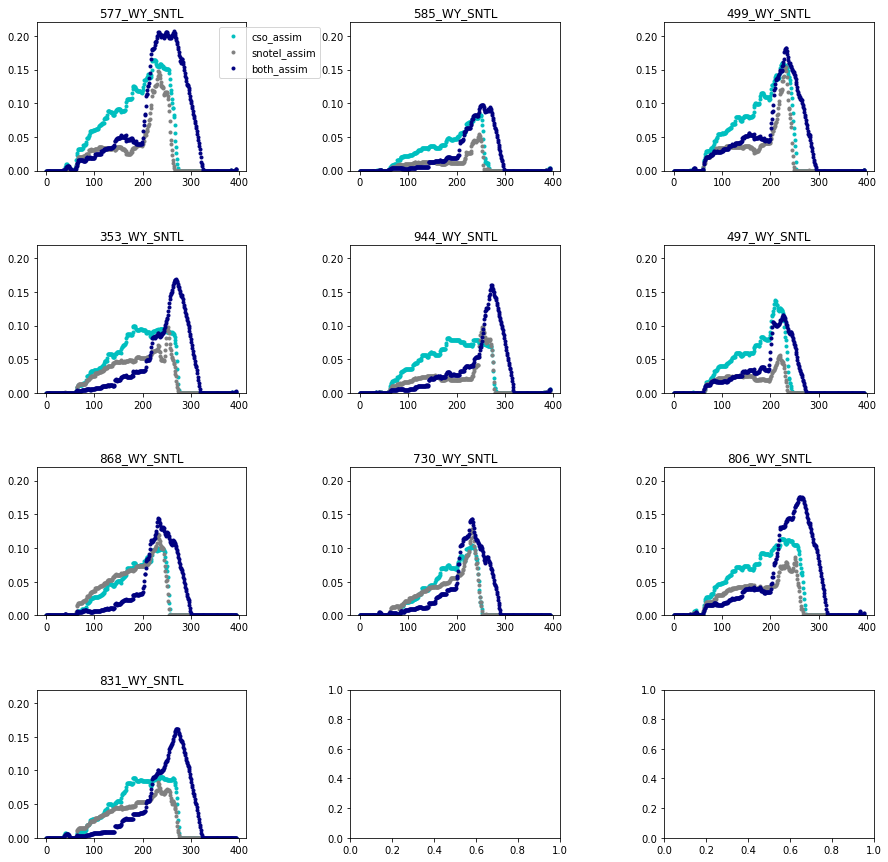

In [7]:
assim_stn = assim.station.values
new = snotel_eval_sites

fig, axs = plt.subplots(nrows=4,figsize=(15, 15), ncols=3, facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.5)
axs = axs.flatten()

#index of snotel assimilation runs
snotel = [i for i, x in enumerate(assim.assim_run.values) if search('snotel', x)]
#index of cso assimilation runs
cso = [i for i, x in enumerate(assim.assim_run.values) if search('cso', x)]
#index of base SM runs
base = [i for i, x in enumerate(assim.assim_run.values) if search('bas', x)]
# #index of combination cso & snotel SM runs
both = [i for i, x in enumerate(assim.assim_run.values) if search('both', x)]

# create a swe plot at each station with assim runs in grey and stn swe in red 
for i in range(len(assim.station.values)):
    
    nam = assim.station.values[i]
    inswe = assim.swe[:,i,:].values
    axs[i].plot(np.std(inswe[cso,:],axis =0),color = 'c',marker='.',linestyle = 'None');   
    axs[i].plot(np.std(inswe[snotel,:],axis =0),color = 'grey',marker='.',linestyle = 'None');
    axs[i].plot(np.std(inswe[both,:],axis =0),color = 'navy',marker='.',linestyle = 'None');     
#    axs[i].plot(np.transpose(inswe[base,:]),color = 'k');
#    axs[i].plot(snotel_swe_all[nam].values,color = 'r');
    axs[i].set_title(nam)
    axs[i].set_ylim((0,.22))

    if i == 0:
        axs[i].legend(['cso_assim','snotel_assim','both_assim'],bbox_to_anchor=(.85, 1), loc='upper left',)     

In [8]:
figpath = '/nfs/attic/dfh/Aragon2/CSOfigs/'+domain+'/'
path = figpath + 'STD_swe_ensembles_'+str(water_year)+'.png'
fig.savefig(path, dpi=300)

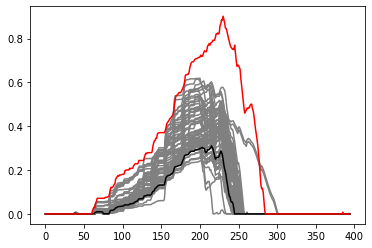

In [28]:
i =6
nam = assim.station.values[i]
inswe = assim.swe[:,i,:].values
plt.plot(np.transpose(inswe),color = 'grey');
plt.plot(np.transpose(inswe[0,:]),color = 'k');
plt.plot(snotel_swe_all[nam].values,color = 'r');

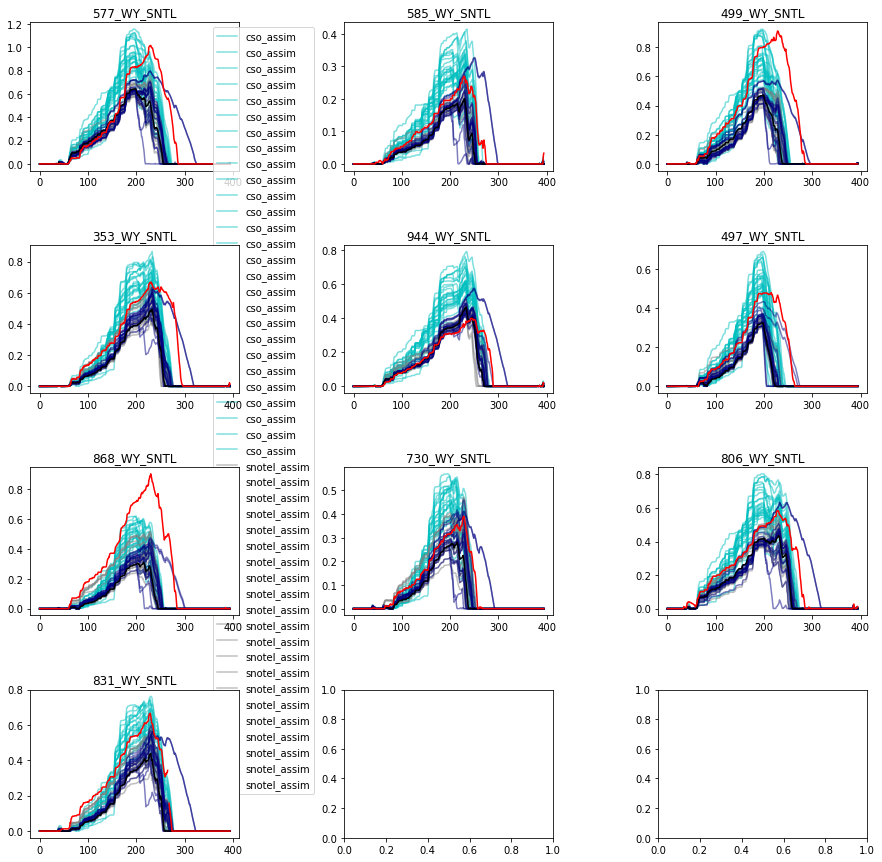

In [5]:
assim_stn = assim.station.values
new = snotel_eval_sites

fig, axs = plt.subplots(nrows=4,figsize=(15, 15), ncols=3, facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.5)
axs = axs.flatten()

#index of snotel assimilation runs
snotel = [i for i, x in enumerate(assim.assim_run.values) if search('snotel', x)]
#index of cso assimilation runs
cso = [i for i, x in enumerate(assim.assim_run.values) if search('cso', x)]
#index of base SM runs
base = [i for i, x in enumerate(assim.assim_run.values) if search('bas', x)]
# #index of combination cso & snotel SM runs
both = [i for i, x in enumerate(assim.assim_run.values) if search('both', x)]

# create a swe plot at each station with assim runs in grey and stn swe in red 
for i in range(len(assim.station.values)):
    
    nam = assim.station.values[i]
    inswe = assim.swe[:,i,:].values
    axs[i].plot(np.transpose(inswe[cso,:]),color = 'c',alpha = .5);   
    axs[i].plot(np.transpose(inswe[snotel,:]),color = 'grey',alpha = .5);
    axs[i].plot(np.transpose(inswe[both,:]),color = 'navy',alpha = .5);     
    axs[i].plot(np.transpose(inswe[base,:]),color = 'k');
    axs[i].plot(snotel_swe_all[nam].values,color = 'r');
    axs[i].set_title(nam)

    if i == 0:
        axs[i].legend(['baseline', 'obs','cso_assim','snotel_assim'],bbox_to_anchor=(.85, 1), loc='upper left',)     

In [15]:
figpath = '/nfs/attic/dfh/Aragon2/CSOfigs/'+domain+'/'
path = figpath + 'EVALassim_swe_line.png'
fig.savefig(path, dpi=300)

In [ ]:
ss.score.loc[ranked_runs[0],:,'KGE'].values

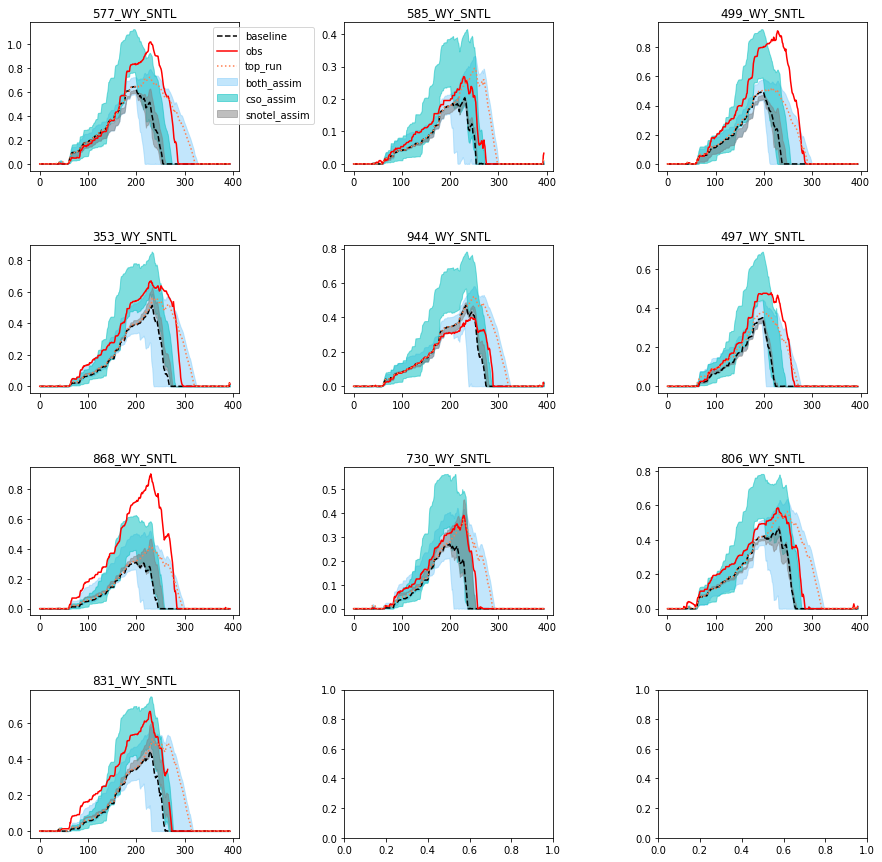

In [20]:
assim_stn = assim.station.values
new = snotel_eval_sites

fig, axs = plt.subplots(nrows=4,figsize=(15, 15), ncols=3, facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.5)
axs = axs.flatten()

#index of snotel assimilation runs
snotel = [i for i, x in enumerate(assim.assim_run.values) if search('snotel', x)]
#index of cso assimilation runs
cso = [i for i, x in enumerate(assim.assim_run.values) if search('cso', x)]
#index of base SM runs
#base = [i for i, x in enumerate(assim.assim_run.values) if search('bas', x)]
#index of top SM run
top = [i for i, x in enumerate(assim.assim_run.values) if search(ranked_runs[0], x)]

# create a swe plot at each station with assim runs in grey and stn swe in red 
for i in range(len(assim.station.values)):
    
    nam = assim.station.values[i]
    inswe = assim.swe[:,i,:].values
    bothmn = np.min(np.transpose(inswe[both,:]), axis = 1)
    bothmx = np.max(np.transpose(inswe[both,:]), axis = 1)
    axs[i].fill_between(np.arange(0,len(bothmn)),bothmn,bothmx,color = 'lightskyblue',alpha = .5);
    csomn = np.min(np.transpose(inswe[cso,:]), axis = 1)
    csomx = np.max(np.transpose(inswe[cso,:]), axis = 1)
    axs[i].fill_between(np.arange(0,len(csomn)),csomn,csomx,color = 'c',alpha = .5);
    snotelmn = np.min(np.transpose(inswe[snotel,:]), axis = 1)
    snotelmx = np.max(np.transpose(inswe[snotel,:]), axis = 1)
    axs[i].fill_between(np.arange(0,len(snotelmn)),snotelmn,snotelmx,color = 'grey',alpha = .5);
    axs[i].plot(np.transpose(inswe[base,:]),color = 'k',linestyle = '--');
    axs[i].plot(snotel_swe_all[nam].values,color = 'r');
    axs[i].plot(np.transpose(inswe[top,:]),color = 'coral',linestyle = ':');
    axs[i].set_title(nam)
    if i == 0:
        axs[i].legend(['baseline', 'obs','top_run','both_assim','cso_assim','snotel_assim'],bbox_to_anchor=(.85, 1), loc='upper left',) 

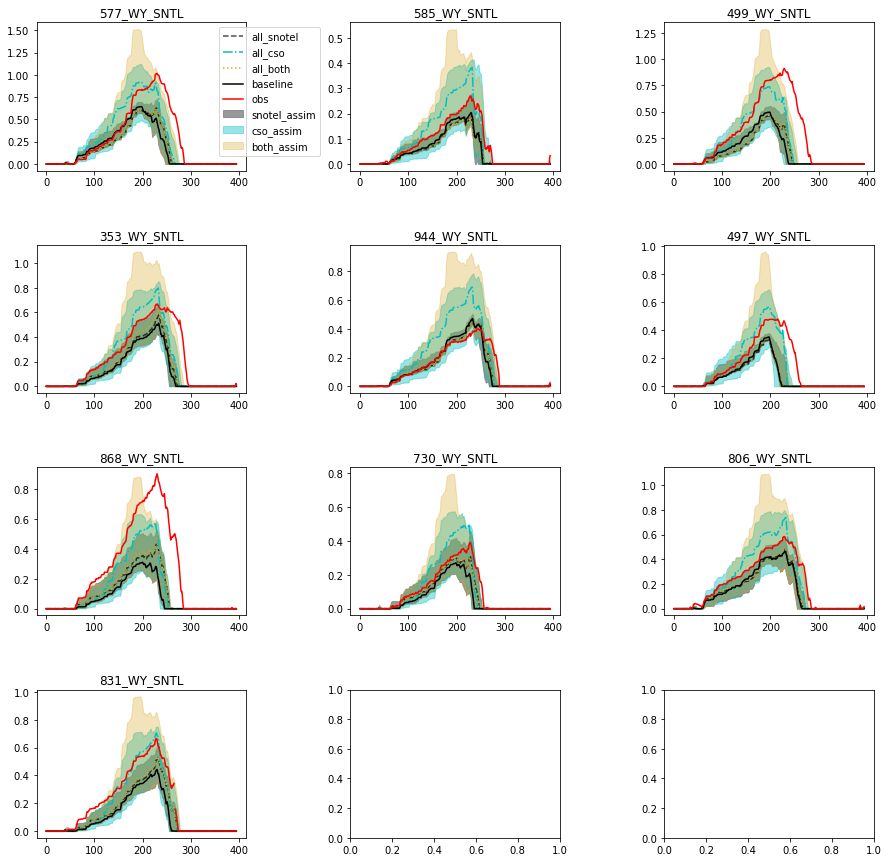

In [25]:
assim_stn = assim.station.values
new = snotel_eval_sites

fig, axs = plt.subplots(nrows=4,figsize=(15, 15), ncols=3, facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.5)
axs = axs.flatten()

#index of snotel assimilation runs
snotel = [i for i, x in enumerate(assim.assim_run.values) if search('snotel', x)]
#index of cso assimilation runs
cso = [i for i, x in enumerate(assim.assim_run.values) if search('cso', x)]
#index of base SM runs
base = [i for i, x in enumerate(assim.assim_run.values) if search('bas', x)]
#index of all snotel SM run
all_snotel = [i for i, x in enumerate(assim.assim_run.values) if search('snotel_all', x)]
#index of all snotel SM run
all_cso = [i for i, x in enumerate(assim.assim_run.values) if search('cso_all', x)]
#index of all snotel SM run
all_both = [i for i, x in enumerate(assim.assim_run.values) if search('both_all', x)]

# create a swe plot at each station with assim runs in grey and stn swe in red 
for i in range(len(assim.station.values)):
    
    nam = assim.station.values[i]
    inswe = assim.swe[:,i,:].values
    snotelmn = np.min(np.transpose(inswe[snotel,:]), axis = 1)
    snotelmx = np.max(np.transpose(inswe[snotel,:]), axis = 1)
    axs[i].fill_between(np.arange(0,len(snotelmn)),snotelmn,snotelmx,color = 'grey',alpha = .8);
    csomn = np.min(np.transpose(inswe[cso,:]), axis = 1)
    csomx = np.max(np.transpose(inswe[cso,:]), axis = 1)
    axs[i].fill_between(np.arange(0,len(csomn)),csomn,csomx,color = 'c',alpha = .4);
    bothmn = np.min(np.transpose(inswe[both,:]), axis = 1)
    bothmx = np.max(np.transpose(inswe[both,:]), axis = 1)
    axs[i].fill_between(np.arange(0,len(bothmn)),bothmn,bothmx,color = 'goldenrod',alpha = .3);
    axs[i].plot(np.transpose(inswe[all_snotel,:]),color = 'k',alpha=.7,linestyle = '--');
    axs[i].plot(np.transpose(inswe[all_cso,:]),color = 'c',linestyle = '-.');
    axs[i].plot(np.transpose(inswe[all_both,:]),color = 'goldenrod',linestyle = ':');
    axs[i].plot(np.transpose(inswe[base,:]),color = 'k');
    axs[i].plot(snotel_swe_all[nam].values,color = 'r');
    axs[i].set_title(nam)
    if i == 0:
        axs[i].legend(['all_snotel','all_cso','all_both','baseline', 'obs','snotel_assim','cso_assim','both_assim'],bbox_to_anchor=(.85, 1), loc='upper left',) 

In [63]:
path = figpath + 'EVALassim_swe_fill_all_'+str(water_year)+'.png'
fig.savefig(path, dpi=300)

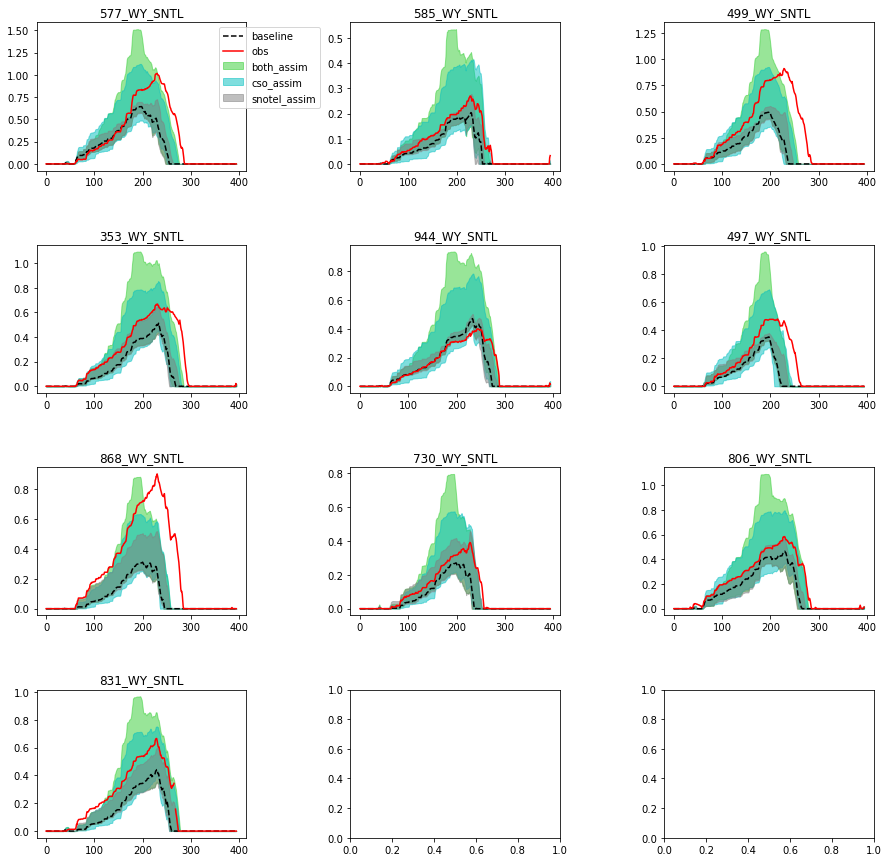

In [26]:
assim_stn = assim.station.values
new = snotel_eval_sites

fig, axs = plt.subplots(nrows=4,figsize=(15, 15), ncols=3, facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.5)
axs = axs.flatten()

#index of snotel assimilation runs
snotel = [i for i, x in enumerate(assim.assim_run.values) if search('snotel', x)]
#index of cso assimilation runs
cso = [i for i, x in enumerate(assim.assim_run.values) if search('cso', x)]
#index of base SM runs
base = [i for i, x in enumerate(assim.assim_run.values) if search('base', x)]

# create a swe plot at each station with assim runs in grey and stn swe in red 
for i in range(len(assim.station.values)):
    
    nam = assim.station.values[i]
    inswe = assim.swe[:,i,:].values
    bothmn = np.min(np.transpose(inswe[both,:]), axis = 1)
    bothmx = np.max(np.transpose(inswe[both,:]), axis = 1)
    axs[i].fill_between(np.arange(0,len(bothmn)),bothmn,bothmx,color = 'limegreen',alpha = .5);
    csomn = np.min(np.transpose(inswe[cso,:]), axis = 1)
    csomx = np.max(np.transpose(inswe[cso,:]), axis = 1)
    axs[i].fill_between(np.arange(0,len(csomn)),csomn,csomx,color = 'c',alpha = .5);
    snotelmn = np.min(np.transpose(inswe[snotel,:]), axis = 1)
    snotelmx = np.max(np.transpose(inswe[snotel,:]), axis = 1)
    axs[i].fill_between(np.arange(0,len(snotelmn)),snotelmn,snotelmx,color = 'grey',alpha = .5);
    axs[i].plot(np.transpose(inswe[base,:]),color = 'k',linestyle = '--');
    axs[i].plot(snotel_swe_all[nam].values,color = 'r');
    axs[i].set_title(nam)
    if i == 0:
        axs[i].legend(['baseline', 'obs','both_assim','cso_assim','snotel_assim'],bbox_to_anchor=(.85, 1), loc='upper left',) 

In [19]:
path = figpath + 'EVALassim_swe_fill_'+str(water_year)+'.png'
fig.savefig(path, dpi=300)

## cross plots

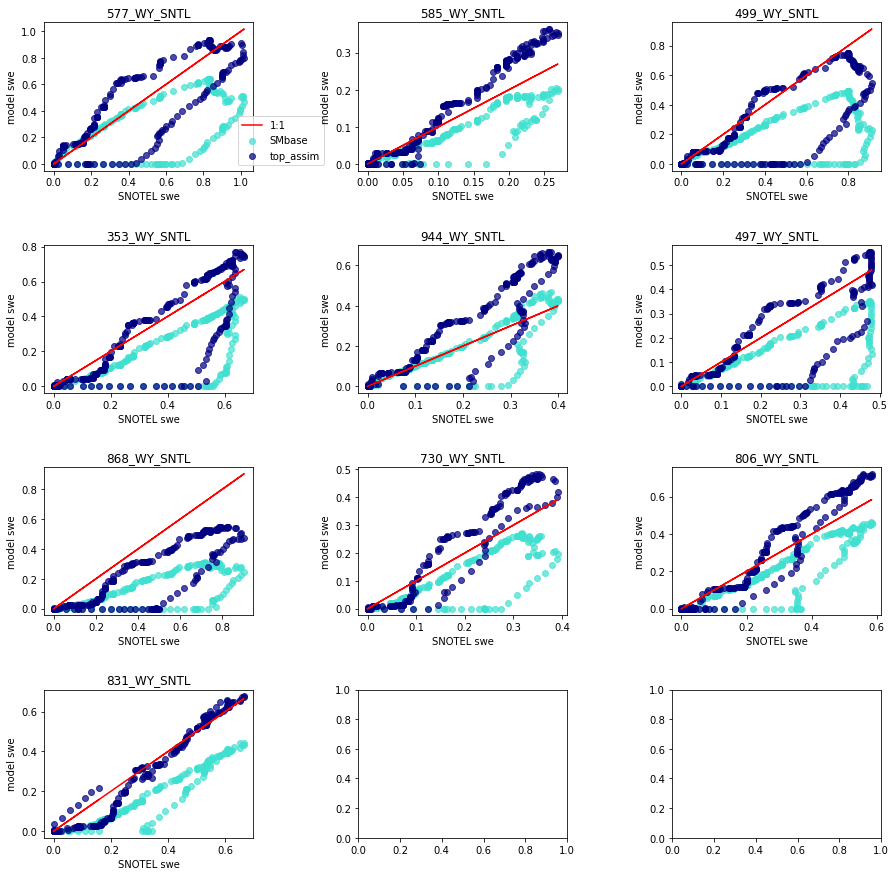

In [32]:
new = snotel_eval_sites

i=0

fig, axs = plt.subplots(nrows=4,figsize=(15, 15), ncols=3, facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.5)
axs = axs.flatten()

for i in range(len(new)):
    
        
    nam = assim.station.values[i]
    inswe = assim.swe[:,i,:]
    base_swe = inswe.loc['baseline',:].values
    swe1 = inswe.loc[ranked_runs[0],:].values
    swe2 = inswe.loc[ranked_runs[1],:].values
    swe3 = inswe.loc[ranked_runs[2],:].values
    swe_obs = snotel_swe_all[nam].values

    axs[i].plot(swe_obs,swe_obs,label = 'obs', color = 'r')
    axs[i].scatter(swe_obs,base_swe,label='mod_base',color = 'turquoise',alpha=.7)
    axs[i].scatter(swe_obs,swe3,label='mod_base',color = 'navy',alpha=.7)
    axs[i].set_title(nam)
    axs[i].set_xlabel('SNOTEL swe')
    axs[i].set_ylabel('model swe')
    #axs[i].scatter(swe_obs,swe2,label='mod_base',color = 'turquoise',alpha=.7)
    #axs[i].scatter(swe_obs,swe3,label='mod_base',color = 'paleturquoise',alpha=.7)
    

#     axs[i].set_title('NSE baseSM, snotel, cso:'+str("{:.2f}".format(swe_stats_base[3]))
#              +', '+str("{:.2f}".format(swe_stats_snotel[3]))
#              +', '+str("{:.2f}".format(swe_stats_cso[3])) , fontsize=10,color = color)
    #axs[i].set_ylim([0, 1.6])
    if i == 0:
        axs[i].legend(['1:1', 'SMbase','top_assim'],bbox_to_anchor=(.9, .4), loc='upper left',)  

In [16]:
path = figpath + 'crossplot_top_assim_'+str(water_year)+'.png'
fig.savefig(path, dpi=300)

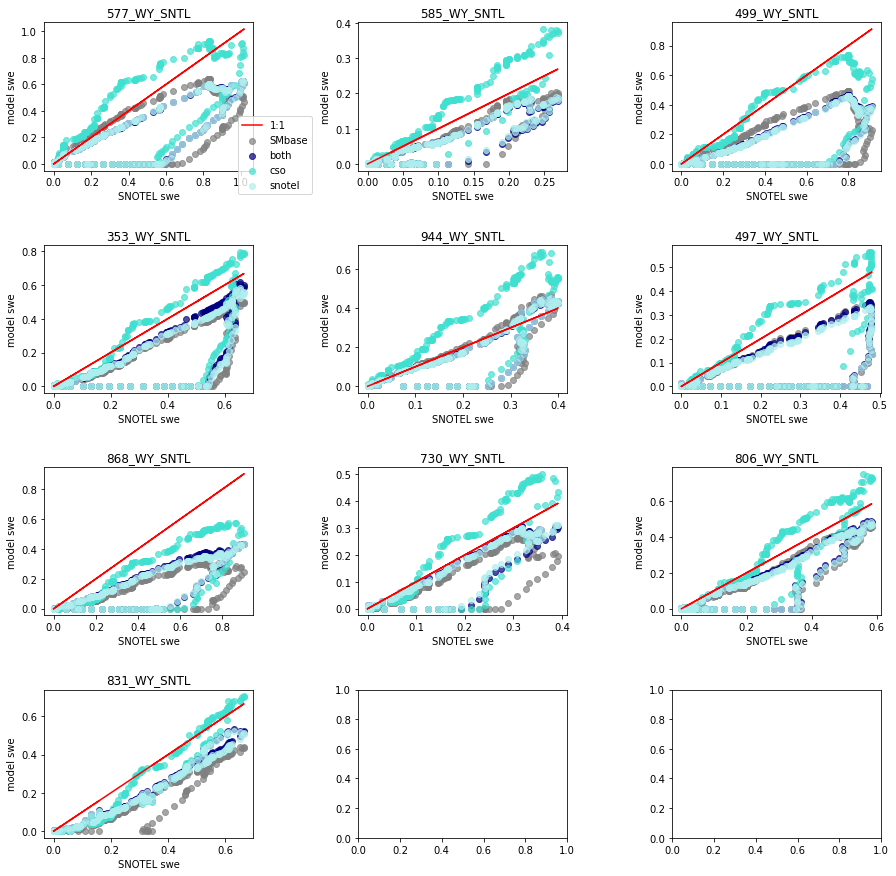

In [28]:
new = snotel_eval_sites

i=0

fig, axs = plt.subplots(nrows=4,figsize=(15, 15), ncols=3, facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.5)
axs = axs.flatten()

for i in range(len(new)):
    
        
    nam = assim.station.values[i]
    inswe = assim.swe[:,i,:]
    base_swe = inswe.loc['baseline',:].values
    swe_both = inswe.loc['both_all',:].values
    swe_cso = inswe.loc['cso_all',:].values
    swe_snotel = inswe.loc['snotel_all',:].values
    swe_obs = snotel_swe_all[nam].values

    axs[i].plot(swe_obs,swe_obs,label = 'obs', color = 'r')
    axs[i].scatter(swe_obs,base_swe,label='mod_base',color = 'grey',alpha=.7)
    axs[i].scatter(swe_obs,swe_both,label='mod_base',color = 'navy',alpha=.7)
    axs[i].set_title(nam)
    axs[i].set_xlabel('SNOTEL swe')
    axs[i].set_ylabel('model swe')
    axs[i].scatter(swe_obs,swe_cso,label='mod_base',color = 'turquoise',alpha=.7)
    axs[i].scatter(swe_obs,swe_snotel,label='mod_base',color = 'paleturquoise',alpha=.7)
    

#     axs[i].set_title('NSE baseSM, snotel, cso:'+str("{:.2f}".format(swe_stats_base[3]))
#              +', '+str("{:.2f}".format(swe_stats_snotel[3]))
#              +', '+str("{:.2f}".format(swe_stats_cso[3])) , fontsize=10,color = color)
    #axs[i].set_ylim([0, 1.6])
    if i == 0:
        axs[i].legend(['1:1', 'SMbase','both','cso','snotel'],bbox_to_anchor=(.9, .4), loc='upper left',)  

In [72]:
path = figpath + 'crossplot_all_assim_'+str(water_year)+'.png'
fig.savefig(path, dpi=300)

# SWE timeseries - all stations 

# SWE map

In [13]:
#function to extract time series from SM .gdat at station location
def get_mod_output(inFile,num_timesteps,nx,ny):
    '''
    inFile: path to swe .gdat from SM
    num_timesteps: number of days in model simulation 
        (since SM currently set up to print daily outputs)
    nx: number of columns in domain
    ny: number of rows in domain
    
    returns: numpy array of modeled SWE values
    '''
    #open the grads model output file, 'rb' indicates reading from binary file
    grads_data = open(inFile,'rb')
    # convert to a numpy array 
    numpy_data = np.fromfile(grads_data,dtype='float32',count=-1)
    #close grads file 
    grads_data.close()
    #reshape the data
    numpy_data = np.reshape(numpy_data,(num_timesteps,nx,ny))

    return numpy_data

In [25]:
inFile = '/scratch/Nina/WY_gdat/assim_2021-05-07/cso_aspect_0.0_swed.gdat'
num_timesteps =(datetime.datetime.strptime(ed,'%Y-%m-%d')-datetime.datetime.strptime(st,'%Y-%m-%d')).days+1
swecube = get_mod_output(inFile,num_timesteps,ny,nx)

In [26]:
swecube.shape

(395, 2476, 1382)

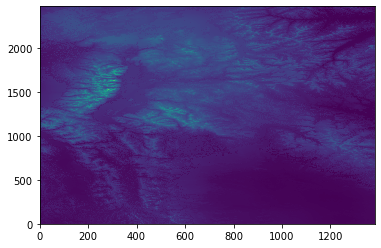

In [27]:
plt.pcolormesh(swecube[100,:,:])

806_WY_SNTL


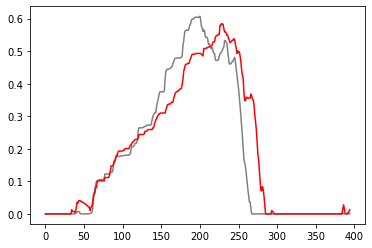

In [44]:
i =8
nam = assim.station.values[i]
print(nam)
inswe = np.squeeze(swecube[:,insites.y_idx[i],insites.x_idx[i]])
plt.plot(np.transpose(inswe),color = 'grey');
plt.plot(snotel_swe_all[nam].values,color = 'r');

# overview plots

In [9]:
# cso geodataframe 
cso_gdf = gpd.read_file(dataPath+'all_cso_'+str(water_year -1) +'_'+str(water_year)+'_meta.geojson')
cso_gdf2 = cso_gdf.to_crs(mod_proj)

snotel_eval_sites2 = snotel_eval_sites.to_crs(mod_proj)

snotel_assim_sites2 = snotel_assim_sites.to_crs(mod_proj)

In [10]:
# DEM data
src = rio.open(dem_path)
bound = src.bounds
minx = bound[0]
miny = bound[1]
maxx = bound[2]
maxy = bound[3]

# elevations
elevation = src.read(1)

# Create and plot the hillshade with earthpy
hillshade = es.hillshade(elevation)

/nfs/attic/dfh/miniconda/envs/snowmodelcal/lib/python3.6/site-packages/geopandas/plotting.py:573: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  "Only specify one of 'column' or 'color'. Using 'color'.", UserWarning
/nfs/attic/dfh/miniconda/envs/snowmodelcal/lib/python3.6/site-packages/geopandas/plotting.py:573: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  "Only specify one of 'column' or 'color'. Using 'color'.", UserWarning
/nfs/attic/dfh/miniconda/envs/snowmodelcal/lib/python3.6/site-packages/geopandas/plotting.py:573: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  "Only specify one of 'column' or 'color'. Using 'color'.", UserWarning


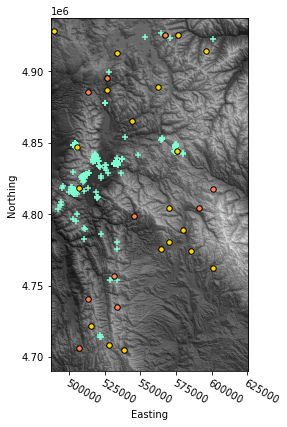

In [22]:
# plot georeferenced SnowModel output with SNOTEL stations 
fig, ax = plt.subplots(1,figsize=(4,6.5))

#hillshade and elevation
ax.imshow(np.flipud(hillshade), origin = [xll,yll], extent = [minx,maxx,miny,maxy],cmap ='gray')
elev = ax.imshow(np.flipud(elevation), origin = [xll,yll], extent = [minx,maxx,miny,maxy],cmap ='gray', alpha = 0.7)

#add cso and snotel sites
cso_gdf2.plot(column='code',color='aquamarine',legend=True, ax=ax,markersize=30,marker='+',label='cso')
snotel_eval_sites2.plot(column='code',color='coral',legend=True, ax=ax,markersize=30,edgecolors='k',label='eval snotel')
snotel_assim_sites2.plot(column='code',color='gold',legend=True, ax=ax,markersize=30,edgecolors='k',label='assim snotel')

# #colorbar
# ax_cbar =plt.colorbar(elev,orientation="vertical")#, fraction=0.07)
# ax_cbar.set_label('Elevation [m]')

ax.set_xlabel('Easting')
ax.set_ylabel('Northing')

plt.setp(ax.get_xticklabels(), rotation=-30, ha="left",rotation_mode="anchor")

plt.savefig(fig_path+ 'assim_sites_'+ str(water_year) + '.png')
plt.show()

# swe anomaly animation 

In [7]:
from datetime import datetime
num_timesteps =(datetime.strptime(ed,'%Y-%m-%d')-datetime.strptime(st,'%Y-%m-%d')).days+1
inpath = '/nfs/attic/dfh/Aragon2/WY_gdat/2019assim_2021-05-07/'
inFile = inpath+ranked_runs[0]+'_swed.gdat'
top_data = get_mod_output(inFile,num_timesteps,ny,nx)

time = pd.date_range(st, periods=num_timesteps)
# # convert to xarray DataArray
# topswe = xr.DataArray(
#     top_data,
#     dims=('time', 'y', 'x'), 
#     coords={'time': time, 'y': np.flip(da.y.values), 'x': da.x.values}
# )

# topswe

NameError: name 'ranked_runs' is not defined

In [38]:
inFile = inpath+'baseline_swed.gdat'
base_data = get_mod_output(inFile,num_timesteps,ny,nx)

time = pd.date_range(st, periods=num_timesteps)
# # convert to xarray DataArray
# baseswe = xr.DataArray(
#     base_data,
#     dims=('time', 'y', 'x'), 
#     coords={'time': time, 'y': np.flip(da.y.values), 'x': da.x.values}
# )

# baseswe

In [45]:
swe_anom = top_data - base_data
mnanom = np.min(swe_anom)
mxanom = np.max(swe_anom)
mnanom, mxanom

(-0.096545964, 2.1039174)

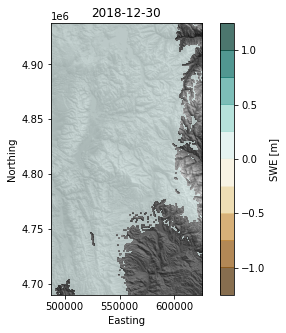

In [88]:

i = 120
# plot georeferenced SnowModel output with SNOTEL stations 
#fig, ax = plt.subplots(1,figsize=(8,10))
fig, ax = plt.subplots(1,figsize=(6.5,5))

#hillshade and elevation
ax.imshow(np.flipud(hillshade), origin = [xll,yll], extent = [minx,maxx,miny,maxy],cmap ='gray')
ax.imshow(np.flipud(elevation), origin = [xll,yll], extent = [minx,maxx,miny,maxy],cmap ='gray', alpha = 0.6)

#add model output
inswe = np.squeeze(swe_anom[i,:,:])
maskswe = np.squeeze(base_data[i,:,:])
b = np.ma.masked_where((inswe < 0.01)&(inswe > -0.01) , inswe)
snow = ax.imshow(b, origin = [xll,yll], extent = [minx,maxx,miny,maxy],cmap =plt.cm.get_cmap('BrBG', 10),alpha = 0.7)
snow.set_clim(-1.25,1.25)

#     #remove tickmarks and tick labels
#     ax.axes.xaxis.set_visible(False)
#     ax.axes.yaxis.set_visible(False)

ax.set_xlabel('Easting')
ax.set_ylabel('Northing')

#colorbar
ax_cbar =plt.colorbar(snow,orientation="vertical")#, fraction=0.07)
ax_cbar.set_label('SWE [m]')

#date title
plt.title(str(time.values[i])[:10]);

In [92]:
#make the images for the movie
for i in range(swe_anom.shape[0]):
    print(i)

    # plot georeferenced SnowModel output with SNOTEL stations 
    #fig, ax = plt.subplots(1,figsize=(8,10))
    fig, ax = plt.subplots(1,figsize=(6.5,5))

    #hillshade and elevation
    ax.imshow(np.flipud(hillshade), origin = [xll,yll], extent = [minx,maxx,miny,maxy],cmap ='gray')
    ax.imshow(np.flipud(elevation), origin = [xll,yll], extent = [minx,maxx,miny,maxy],cmap ='gray', alpha = 0.6)

    #add model output
    inswe = np.squeeze(swe_anom[i,:,:])
    maskswe = np.squeeze(base_data[i,:,:])
    b = np.ma.masked_where((inswe < 0.01)&(inswe > -0.01) , inswe)
    snow = ax.imshow(b, origin = [xll,yll], extent = [minx,maxx,miny,maxy],cmap =plt.cm.get_cmap('BrBG', 10),alpha = 0.7)
    snow.set_clim(-1.25,1.25)

    ax.set_xlabel('Easting')
    ax.set_ylabel('Northing')

    #colorbar
    ax_cbar =plt.colorbar(snow,orientation="vertical")
    ax_cbar.set_label('SWE [m]')

    #date title
    plt.title(str(time.values[i])[:10]);


    plt.savefig("/nfs/attic/dfh/Aragon2/CSOfigs/"+domain+f"/2019_anom/Python_Animation_frame_{i:04}.png")
    plt.close()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [94]:
PNGpath = fig_path+str(water_year)+'_anom/Python_Animation_frame*.png'
GIFpath = fig_path+'SM_Animation_anom_'+str(water_year)+'.gif'

# make the movie
!convert $PNGpath $GIFpath

# snow storage standard deviation plot 

In [11]:
da = xr.open_rasterio(dem_path)
transform = Affine.from_gdal(*da.attrs['transform'])
nx, ny = da.sizes['x'], da.sizes['y']
x, y = np.meshgrid(np.arange(nx)+0.5, np.arange(ny)+0.5) * transform
da

/nfs/attic/dfh/miniconda/envs/snowmodelcal/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Right multiplication will be prohibited in version 3.0
  after removing the cwd from sys.path.


<xarray.DataArray (band: 1, y: 2476, x: 1382)>
[3421832 values with dtype=int16]
Coordinates:
  * band     (band) int64 1
  * y        (y) float64 4.938e+06 4.938e+06 4.937e+06 ... 4.69e+06 4.69e+06
  * x        (x) float64 4.872e+05 4.874e+05 4.874e+05 ... 6.252e+05 6.254e+05
Attributes:
    transform:      (100.0, 0.0, 487200.0, 0.0, -100.0, 4937700.0)
    crs:            +init=epsg:32612
    res:            (100.0, 100.0)
    is_tiled:       1
    nodatavals:     (nan,)
    scales:         (1.0,)
    offsets:        (0.0,)
    descriptions:   ('elevation',)
    AREA_OR_POINT:  Area

In [13]:
gdatPath = '/nfs/attic/dfh/Aragon2/WY_gdat/assim2019/'
filenams = sorted([f for f in listdir(gdatPath) if isfile(join(gdatPath, f))])
filenams

['baseline_swed.gdat',
 'both_all_swed.gdat',
 'both_aspect_0.0_swed.gdat',
 'both_aspect_2.0_swed.gdat',
 'both_aspect_4.0_swed.gdat',
 'both_aspect_6.0_swed.gdat',
 'both_aspect_8.0_swed.gdat',
 'both_day_delta10_swed.gdat',
 'both_day_delta3_swed.gdat',
 'both_day_delta5_swed.gdat',
 'both_day_delta7_swed.gdat',
 'both_elev_0_swed.gdat',
 'both_elev_1_swed.gdat',
 'both_elev_2_swed.gdat',
 'both_elev_3_swed.gdat',
 'both_elev_4_swed.gdat',
 'both_lc_1.0_swed.gdat',
 'both_lc_12.0_swed.gdat',
 'both_lc_2.0_swed.gdat',
 'both_lc_21.0_swed.gdat',
 'both_lc_24.0_swed.gdat',
 'both_lc_6.0_swed.gdat',
 'both_lc_9.0_swed.gdat',
 'both_slope_0_swed.gdat',
 'both_slope_1_swed.gdat',
 'both_slope_2_swed.gdat',
 'both_slope_3_swed.gdat',
 'both_slope_4_swed.gdat',
 'cso_all_swed.gdat',
 'cso_aspect_0.0_swed.gdat',
 'cso_aspect_2.0_swed.gdat',
 'cso_day_delta3_swed.gdat',
 'cso_day_delta5_swed.gdat',
 'cso_elev_0_swed.gdat',
 'cso_elev_1_swed.gdat',
 'cso_elev_2_swed.gdat',
 'cso_lc_1.0_swed.gd

In [10]:
path = '/nfs/attic/dfh/Aragon2/WY_gdat/2019assim_2021-05-07/snotel_all_swed.gdat'
numpy_data = get_mod_output(path,num_timesteps,ny,nx)
time = pd.date_range(st, periods=num_timesteps) # periods=num_mod_timesteps
# convert to xarray DataArray
SMswe = xr.DataArray(
    numpy_data,
    dims=('time', 'y', 'x'), 
    coords={'time': time, 'y': np.flip(da.y.values), 'x': da.x.values}
)

swesnotel_aoc = np.empty([len(SMswe.y), len(SMswe.x)])

for i in range(len(SMswe.y)):
    for j in range(len(SMswe.x)):
        val = SMswe.sel(y = SMswe.y.values[i],x =SMswe.x.values[j])
        swesnotel_aoc[i,j] = trapz(val)

save_nam = gdatPath+'storage/snotel_all_storage.csv'
#pd.DataFrame(swesnotel_aoc).to_csv(save_nam)   

In [112]:
#calculate storage for each assim run 
for fil in range(len(filenams)):
    numpy_data = get_mod_output(gdatPath+filenams[fil],num_timesteps,ny,nx)
    time = pd.date_range(st, periods=num_timesteps) # periods=num_mod_timesteps
    # convert to xarray DataArray
    SMswe = xr.DataArray(
        numpy_data,
        dims=('time', 'y', 'x'), 
        coords={'time': time, 'y': np.flip(da.y.values), 'x': da.x.values}
    )

    swesnotel_aoc = np.empty([len(SMswe.y), len(SMswe.x)])

    for i in range(len(SMswe.y)):
        for j in range(len(SMswe.x)):
            val = SMswe.sel(y = SMswe.y.values[i],x =SMswe.x.values[j])
            swesnotel_aoc[i,j] = trapz(val)

    save_nam = gdatPath+'storage/'+filenams[fil][:-10]+'_storage.csv'
    pd.DataFrame(swesnotel_aoc).to_csv(save_nam)   

KeyboardInterrupt: 

In [12]:
base = genfromtxt(gdatPath+'storage/baseline_storage.csv', delimiter=',')
cso = genfromtxt(gdatPath+'storage/cso_all_storage.csv', delimiter=',')
snotel = genfromtxt(gdatPath+'storage/snotel_all_storage.csv', delimiter=',')
both = genfromtxt(gdatPath+'storage/both_all_storage.csv', delimiter=',')

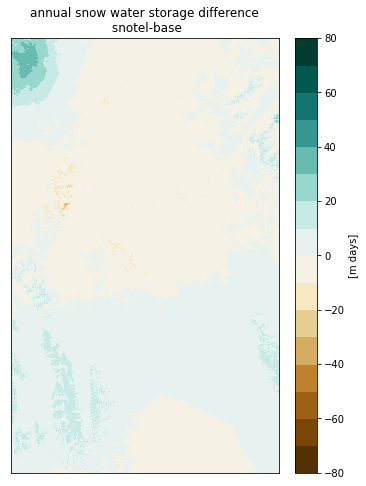

In [25]:
storage_dif_snotel= snotel-base

# plot georeferenced SnowModel output with SNOTEL stations 
fig, ax = plt.subplots(1,figsize=(6,8))
snow = ax.pcolormesh(storage_dif_snotel,vmin=-80,vmax=80,cmap =plt.cm.get_cmap('BrBG', 16))
ax_cbar =plt.colorbar(snow,orientation="vertical")#, fraction=0.07)
ax_cbar.set_label('[m days]')
#ax.set_xlabel('Easting')
#ax.set_ylabel('Northing')
#     #remove tickmarks and tick labels
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
ax.set_title('annual snow water storage difference\n snotel-base')

fig.savefig(fig_path+'storage_dif_snotel'+str(water_year)+'.png', dpi=300)

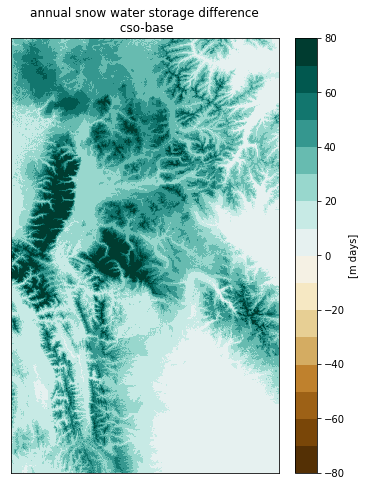

In [26]:
storage_dif_cso= cso-base

# plot georeferenced SnowModel output with SNOTEL stations 
fig, ax = plt.subplots(1,figsize=(6,8))
snow = ax.pcolormesh(storage_dif_cso,vmin=-80,vmax=80,cmap =plt.cm.get_cmap('BrBG', 16))
ax_cbar =plt.colorbar(snow,orientation="vertical")#, fraction=0.07)
ax_cbar.set_label('[m days]')
#ax.set_xlabel('Easting')
#ax.set_ylabel('Northing')
#     #remove tickmarks and tick labels
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
ax.set_title('annual snow water storage difference\n cso-base')

fig.savefig(fig_path+'storage_dif_cso'+str(water_year)+'.png', dpi=300)

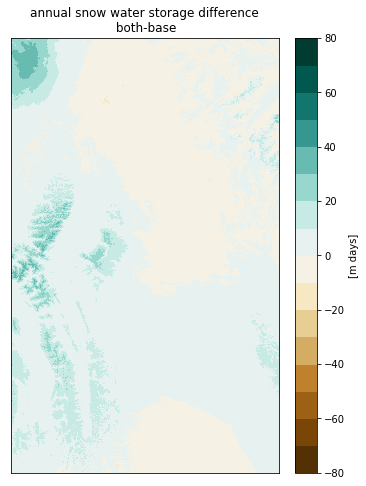

In [28]:
storage_dif_both= both-base

# plot georeferenced SnowModel output with SNOTEL stations 
fig, ax = plt.subplots(1,figsize=(6,8))
snow = ax.pcolormesh(storage_dif_both,vmin=-80,vmax=80,cmap =plt.cm.get_cmap('BrBG', 16))
ax_cbar =plt.colorbar(snow,orientation="vertical")#, fraction=0.07)
ax_cbar.set_label('[m days]')
#ax.set_xlabel('Easting')
#ax.set_ylabel('Northing')
#     #remove tickmarks and tick labels
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
ax.set_title('annual snow water storage difference\n both-base')

fig.savefig(fig_path+'storage_dif_both'+str(water_year)+'.png', dpi=300)

## coeficienct of variance plots

In [19]:
path = "/nfs/attic/dfh/Aragon2/WY_gdat/2019assim_2021-05-07/storage/"
#get all storage files for the both ensemble
files = []
for file in listdir(path):
    if file.startswith("both"):
        files.append(file)
#concatonate storage files
for i in range(len(files)): 
    file = files[i]
    if i == 0:
        storage = genfromtxt(path+file, delimiter=',')
    else:
        storage_tmp = genfromtxt(path+file, delimiter=',')
        storage = np.dstack((storage,storage_tmp))
storage.shape

(2477, 1383, 16)

In [20]:
# compute coefficient of variation 
std = np.std(storage, axis=2)
mean = np.mean(storage, axis=2)
cov = std/mean
cov.shape

/nfs/attic/dfh/miniconda/envs/snowmodelcal/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


(2477, 1383)

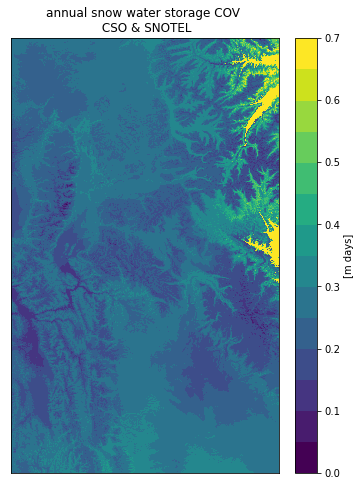

In [21]:
fig, ax = plt.subplots(1,figsize=(6,8))
snow = ax.pcolormesh(cov,vmin=0,vmax=.7,cmap =plt.cm.get_cmap('viridis', 14))
ax_cbar =plt.colorbar(snow,orientation="vertical")#, fraction=0.07)
ax_cbar.set_label('[m days]')
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
ax.set_title('annual snow water storage COV \n CSO & SNOTEL')

fig.savefig(fig_path+'COVstorage_both'+str(water_year)+'.png', dpi=300)

Text(0, 0.5, 'snow storage std [m days]')

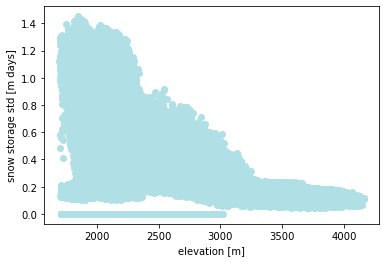

In [13]:
plt.scatter(np.flipud(da.values[0]),cov[:-1,:-1],color='powderblue')
plt.xlabel('elevation [m]')
plt.ylabel('snow storage std [m days]')

#plt.savefig(fig_path+'std_elev_both.png', dpi=300)

In [22]:
path = "/nfs/attic/dfh/Aragon2/WY_gdat/2019assim_2021-05-07/storage/"
#get all storage files for the cso ensemble
files = []
for file in listdir(path):
    if file.startswith("cso"):
        files.append(file)
#concatonate storage files
for i in range(len(files)): 
    file = files[i]
    if i == 0:
        storage_cso = genfromtxt(path+file, delimiter=',')
    else:
        storage_tmp = genfromtxt(path+file, delimiter=',')
        storage_cso = np.dstack((storage_cso,storage_tmp))
# compute coefficient of variation 
std_cso = np.std(storage_cso, axis=2)
mean_cso = np.mean(storage_cso, axis=2)
cov_cso = std_cso/mean_cso
cov_cso.shape

/nfs/attic/dfh/miniconda/envs/snowmodelcal/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide


(2477, 1383)

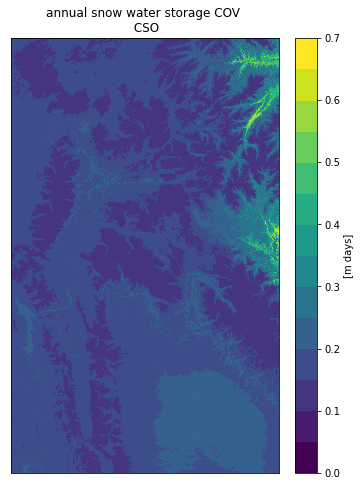

In [26]:
fig, ax = plt.subplots(1,figsize=(6,8))
snow = ax.pcolormesh(cov_cso,vmin=0,vmax=.7,cmap =plt.cm.get_cmap('viridis', 14))
ax_cbar =plt.colorbar(snow,orientation="vertical")#, fraction=0.07)
ax_cbar.set_label('[m days]')
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
ax.set_title('annual snow water storage COV \n CSO')

fig.savefig(fig_path+'COVstorage_cso'+str(water_year)+'.png', dpi=300)

Text(0, 0.5, 'snow storage std [m days]')

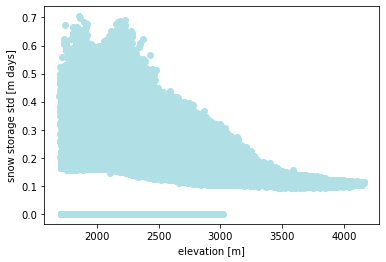

In [28]:
plt.scatter(np.flipud(da.values[0]),cov_cso[:-1,:-1],color='powderblue')
plt.xlabel('elevation [m]')
plt.ylabel('snow storage std [m days]')

#plt.savefig(fig_path+'std_elev_both.png', dpi=300)

In [24]:
path = "/nfs/attic/dfh/Aragon2/WY_gdat/2019assim_2021-05-07/storage/"
#get all storage files for the snotel ensemble
files = []
for file in listdir(path):
    if file.startswith("snotel"):
        files.append(file)
#concatonate storage files
for i in range(len(files)): 
    file = files[i]
    if i == 0:
        storage_snotel = genfromtxt(path+file, delimiter=',')
    else:
        storage_tmp = genfromtxt(path+file, delimiter=',')
        storage_snotel = np.dstack((storage_snotel,storage_tmp))
# compute coefficient of variation 
std_snotel = np.std(storage_snotel, axis=2)
mean_snotel = np.mean(storage_snotel, axis=2)
cov_snotel = std_snotel/mean_snotel
cov_snotel.shape

/nfs/attic/dfh/miniconda/envs/snowmodelcal/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide


(2477, 1383)

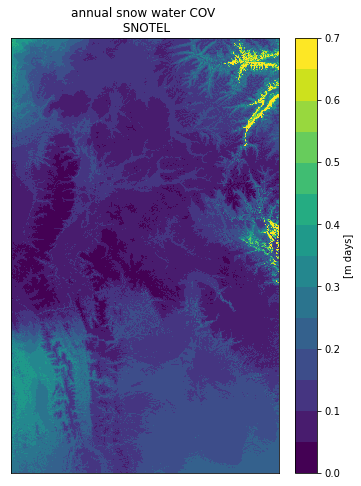

In [27]:
fig, ax = plt.subplots(1,figsize=(6,8))
snow = ax.pcolormesh(cov_snotel,vmin=0,vmax=.7,cmap =plt.cm.get_cmap('viridis', 14))
ax_cbar =plt.colorbar(snow,orientation="vertical")#, fraction=0.07)
ax_cbar.set_label('[m days]')
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
ax.set_title('annual snow water COV \n SNOTEL')

fig.savefig(fig_path+'COVstorage_snotel'+str(water_year)+'.png', dpi=300)

Text(0, 0.5, 'snow storage std [m days]')

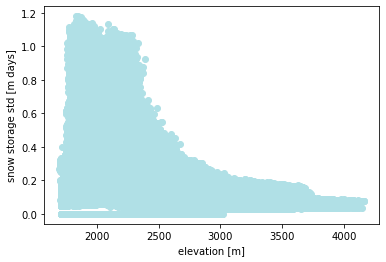

In [29]:
plt.scatter(np.flipud(da.values[0]),cov_snotel[:-1,:-1],color='powderblue')
plt.xlabel('elevation [m]')
plt.ylabel('snow storage std [m days]')

#plt.savefig(fig_path+'std_elev_both.png', dpi=300)

# terrain features

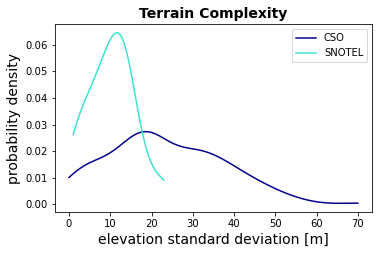

In [52]:
fig, axs = plt.subplots(1)  
data = cso_gdf['tc']
kde = stats.gaussian_kde(data)
x1 = np.linspace(data.min(), data.max(), 100)
p1 = kde(x1)

axs.plot(x1,p1,color = 'darkblue',label='CSO')

data = snotel_assim_sites['tc']
kde = stats.gaussian_kde(data)
x = np.linspace(data.min(), data.max(), 100)
p = kde(x)

axs.plot(x,p,color = 'turquoise',label='SNOTEL')

axs.set_xlabel('elevation standard deviation [m]', fontsize=14)
axs.set_ylabel('probability density', fontsize=14)
axs.set_title('Terrain Complexity', fontsize=14, fontweight='bold')

plt.legend()
plt.tight_layout()

fig.set_size_inches(5.25,3.5)
path = figpath+'tc_pdf_'+str(water_year)+'.pdf'
fig.savefig(path, format='pdf', dpi=300)

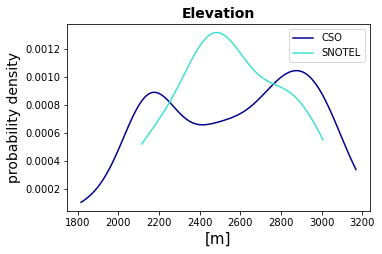

In [53]:
fig, axs = plt.subplots(1)  
data = cso_gdf['dem_elev']
kde = stats.gaussian_kde(data)
x1 = np.linspace(data.min(), data.max(), 100)
p1 = kde(x1)

axs.plot(x1,p1,color = 'darkblue',label='CSO')

data = snotel_assim_sites['dem_elev']
kde = stats.gaussian_kde(data)
x = np.linspace(data.min(), data.max(), 100)
p = kde(x)

axs.plot(x,p,color = 'turquoise',label='SNOTEL')

axs.set_xlabel('[m]', fontsize=15)
axs.set_ylabel('probability density', fontsize=14)
axs.set_title('Elevation', fontsize=14, fontweight='bold')

plt.legend()
plt.tight_layout()

fig.set_size_inches(5.25,3.5)
path = figpath+'elev_pdf_'+str(water_year)+'.pdf'
fig.savefig(path, format='pdf', dpi=300)

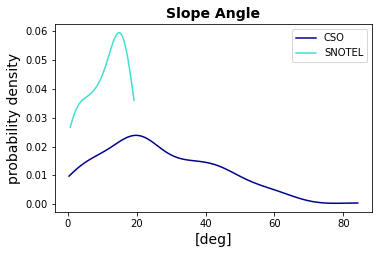

In [54]:
fig, axs = plt.subplots(1)  
data = cso_gdf['slope']
kde = stats.gaussian_kde(data)
x1 = np.linspace(data.min(), data.max(), 100)
p1 = kde(x1)

axs.plot(x1,p1,color = 'darkblue',label='CSO')

data = snotel_assim_sites['slope']
kde = stats.gaussian_kde(data)
x = np.linspace(data.min(), data.max(), 100)
p = kde(x)

axs.plot(x,p,color = 'turquoise',label='SNOTEL')

axs.set_xlabel('[deg]', fontsize=14)
axs.set_ylabel('probability density', fontsize=14)
axs.set_title('Slope Angle', fontsize=14, fontweight='bold')

plt.legend()
plt.tight_layout()

fig.set_size_inches(5.25,3.5)
path = figpath+'slope_pdf_'+str(water_year)+'.pdf'
fig.savefig(path, format='pdf', dpi=300)

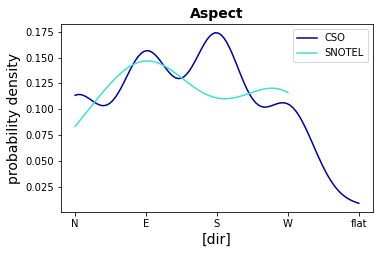

In [55]:
fig, axs = plt.subplots(1)  
data = cso_gdf['aspect']
kde = stats.gaussian_kde(data)
x1 = np.linspace(data.min(), data.max(),100)
p1 = kde(x1)

axs.plot(x1,p1,color = 'darkblue',label='CSO')

data = snotel_assim_sites['aspect']
kde = stats.gaussian_kde(data)
x = np.linspace(data.min(), data.max(), 100)
p = kde(x)

axs.plot(x,p,color = 'turquoise',label='SNOTEL')

axs.set_xlabel('[dir]', fontsize=14)
axs.set_ylabel('probability density', fontsize=14)
axs.set_title('Aspect', fontsize=14, fontweight='bold')

# Set the ticks and ticklabels for all axes
plt.setp(axs, xticks=[0, 2,4,6,8],xticklabels=['N', 'E', 'S', 'W', 'flat'])

plt.legend()
plt.tight_layout()

fig.set_size_inches(5.25,3.5)
path = figpath+'aspect_pdf_'+str(water_year)+'.pdf'
fig.savefig(path, format='pdf', dpi=300)

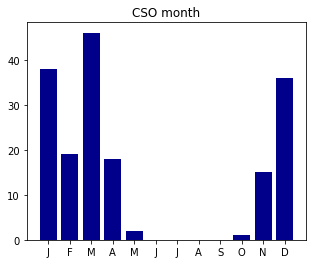

In [13]:
labels, counts = np.unique(cso_gdf.M, return_counts=True)
fig, ax = plt.subplots(1,figsize=[5,4])
ax.bar(labels, counts, align='center',color = 'darkblue')
ax.set_title('CSO month')
plt.setp(ax, xticks=[1,2,3,4,5,6,7,8,9,10,11,12],xticklabels=['J','F','M','A','M','J','J','A','S','O','N','D'])
plt.show()

In [14]:
fig.set_size_inches(5.25,3.5)
path = figpath+'cso_month_'+str(water_year)+'.pdf'
fig.savefig(path, format='pdf', dpi=300)

In [3]:
snotel_assim_sites.columns

Index(['code', 'longitude', 'latitude', 'name', 'elevation_m', 'easting',
       'northing', 'x', 'y', 'dem_elev', 'slope', 'aspect', 'lc', 'tc',
       'cluster', 'geometry'],
      dtype='object')